# **[MC906] Projeto Final**: Detecção de Desastres

O objetivo desse projeto é construir e avaliar modelos de aprendizado de máquina que classifiquem quais Tweets são sobre desastres reais e quais não são.

## **Acessar Diretório do Projeto**

Esse Notebook assume que você está executando o código dentro da pasta `Projeto Final/Código`, que contém todos os códigos fontes relativos a esse trabalho. Para acessar o diretório no Colab é preciso criar um atalho em seu Drive (right click no diretório -> "Adicionar atalho ao Google Drive") e executar as células abaixo:

In [ ]:
# Conectar ao Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Diretório do Projeto (/content/drive/My Drive/{path até Projeto Final/Código}), 
# dependendo da onde se localiza o atalho no seu Drive
% cd '/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código'
! ls

/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final
'Attention CNN'			 Dataset
 Backups			'Dense Neural Networks'
 BERT				 Glove
 best_model_attention.h5	'Logistic Regression and SVM'
 best_model_BERT.h5		'Melhor Pré-Processamento'
 best_model_CNN.h5		 __pycache__
 best_model_DNN.h5		'Quasi-Recurrent Networks'
 best_model_RNN_glove.h5	'Recurrent Neural Networks'
 best_model_RNN.h5		 Relatório
 best_model_RNN_pool.h5		 tokenization.py
'Convolutional Neural Network'	 utils.py


## **Dependências:**

In [ ]:
# Imports de pacotes instalados
from os.path import join, exists
import pandas as pd
from tensorflow.keras.layers import Activation, Dense, Input, Embedding
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

# Imports locais
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Dataset:**

Utilizamos um *dataset* disponível no site [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (em inglês). Cada tweet apresenta três atributos: seu conteúdo (`text`), uma palavra-chave (`keyword`, opcional) e a localização da onde foi enviado (`location`, opcional). Como só usaremos o texto, removemos os dois últimos.

In [ ]:
# Ler e limpar dados (removendo colunas do id, keyword e location)
train = pd.read_csv("../Dataset/train.csv")
train = train.drop(['id','keyword','location'], axis=1)

# Imprimir alguns dados
print(train.head())
vals = train.groupby('target').count()
print("\nSome General insights:")
print(f"Figure of Speech: {vals.iloc[0]['text']*100/len(train):.2f}%")
print(f"Actual Accidents: {vals.iloc[1]['text']*100/len(train):.2f}%")

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Some General insights:
Figure of Speech: 57.03%
Actual Accidents: 42.97%


## **Pré-processamento:**

Aplicamos uma série de passos para o pré-processamento textual do dataset:
* Remoção de pontuações, *stop words* e palavras menos frequentes.
* Tokenization: Separação das frases em tokens/palavras e pontuações.
* Stemming: corte de prefixos e sufixo das palavras de forma indiscriminada. Associa as palavras à uma raiz comum.
* One Hot Encoding: Conversão dos valores categóricos em vetores binários.

In [ ]:
# Limpar texto
print(f"Raw Tweet:\n\t",train.text[1])
train.text = train.text.apply(clean_up)
print("\nRemoved Punctuation and Special Chars:\n\t", train.text[1])

# Aplicar tokenização
train.text = train.text.apply(word_tokenize)
print("\nTokenized Tweet:\n\t", train.text[1])

# Remover stop words e aplicar stemming
show_wordcount(train.text, "\nBefore Removal:")
train.text = train.text.apply(stop_words)
print("\nRemoved Stop Words:\n\t", train.text[1])
train.text = train.text.apply(stemming)
print("\nStemmed Tweet:\n\t",train.text[1])
show_wordcount(train.text, "\nAfter Removal:")

Raw Tweet:
	 Forest fire near La Ronge Sask. Canada

Removed Punctuation and Special Chars:
	 Forest fire near La Ronge Sask Canada

Tokenized Tweet:
	 ['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', 'Canada']

Before Removal:
Amount of Words: 105647
Amount of Distinct Words: 21526

Removed Stop Words:
	 ['fire', 'Ronge', 'Canada', 'Forest', 'La', 'near', 'Sask']

Stemmed Tweet:
	 ['fire', 'rong', 'canada', 'forest', 'la', 'near', 'sask']

After Removal:
Amount of Words: 77292
Amount of Distinct Words: 18502


In [ ]:
show_wordcount(train.text, '\nBefore Removal:')
words, counts = count_words(train.text)

# Criar lista de palavras pouco frequentes
MIN_FREQ = 2
discard = []
for (w,c) in zip(words, counts[0]):
    if c < MIN_FREQ : 
      discard.append(w)

# Criar conjunto com as palavras selecionadas pelo countvectorizer
# descartando as palavras pouco frequentes, e remover as palavras
# do tweet que não pertençam a esse conjunto
print(f"\nDiscarding {len(discard)} Words...")
select = set(words)-set(discard)
train.text = train.text.apply(lambda x : list(set(x) & select))
show_wordcount(train.text, '\nAfter Removal:')


Before Removal:
Amount of Words: 77292
Amount of Distinct Words: 18502

Discarding 13145 Words...

After Removal:
Amount of Words: 62736
Amount of Distinct Words: 5320


In [ ]:
# Aplicar One Hot Encoding 
labels = LabelEncoder().fit(list(select))
encoded = train.text.apply(labels.transform) # Transforming words to labels
encoded = encoded.apply(lambda x : onehotencoding(x, len(select)))

In [ ]:
# Array numpy dos tweets pré-processados e targets
X = np.array(encoded.tolist())
Y = np.array([[x] for x in train.target.tolist()]) 

## **Modelo:** Redes Neurais Densas

Testamos um modelo de rede profunda com apenas camadas densas visando alcançar bons resultados preliminares.

In [ ]:
def NN(max_words = 1000, max_len = X.shape[1]):
  ''' Função que constrói o modelo DNN. '''

    inputs = Input(name='inputs',shape=[max_len])
    layer = Dense(500, name='FC3', activation='relu')(inputs)
    layer = Dense(250, name='FC4', activation='relu')(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
# Construir e compilar modelo
neural_network = NN()
neural_network.summary()
neural_network.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5357)]            0         
_________________________________________________________________
FC3 (Dense)                  (None, 500)               2679000   
_________________________________________________________________
FC4 (Dense)                  (None, 250)               125250    
_________________________________________________________________
out_layer (Dense)            (None, 1)                 251       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 2,804,501
Trainable params: 2,804,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_DNN.h5', save_best_only=True)]
history = neural_network.fit(X,Y,batch_size=100,epochs=15, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_DNN.h5'):
    neural_network = load_model('./Modelos/best_model_DNN.h5')

Epoch 1/15
69/69 [==============================] - 1s 12ms/step - loss: 0.5217 - accuracy: 0.7431 - val_loss: 0.4413 - val_accuracy: 0.8031
Epoch 2/15
69/69 [==============================] - 0s 3ms/step - loss: 0.2714 - accuracy: 0.8946 - val_loss: 0.4840 - val_accuracy: 0.7940
Epoch 3/15
69/69 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9461 - val_loss: 0.5732 - val_accuracy: 0.7835
Epoch 4/15
69/69 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9644 - val_loss: 0.6823 - val_accuracy: 0.7782
Epoch 5/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9710 - val_loss: 0.7445 - val_accuracy: 0.7835
Epoch 6/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9756 - val_loss: 0.8219 - val_accuracy: 0.7835
Epoch 7/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0498 - accuracy: 0.9765 - val_loss: 0.9178 - val_accuracy: 0.7887
Epoch 8/15
69/69 [=

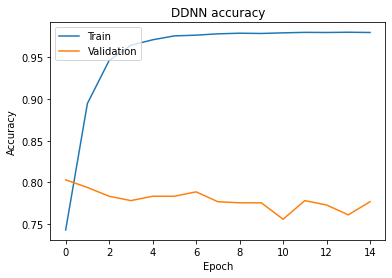

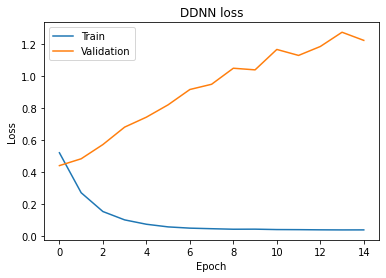

In [ ]:
# Plotar métricas
plot_graphs(history, "DDNN")